In [55]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import datetime
from sklearn.metrics import mean_squared_error

# What did the data look like originally?

In [2]:
# Load the original data set - BEFORE transformations
original_data = pd.read_csv('original_data.csv')
original_data['Date'] = pd.to_datetime(original_data['Date'], infer_datetime_format=True)

# Display
original_data.head()

,Unnamed: 0,Date,Start_Station_Capacity,Station_Number,Status,Bike_Count,Count_Percent_Capacity
0,24,2015-07-01 08:25:00,19.0,31116,add bike,1.0,5.263158
1,26,2015-07-01 08:26:00,19.0,31116,subtract bike,0.0,0.000000
2,28,2015-07-01 09:42:00,19.0,31116,add bike,1.0,5.263158
3,30,2015-07-01 09:55:00,19.0,31116,subtract bike,0.0,0.000000
4,32,2015-07-01 10:38:00,19.0,31116,add bike,1.0,5.263158


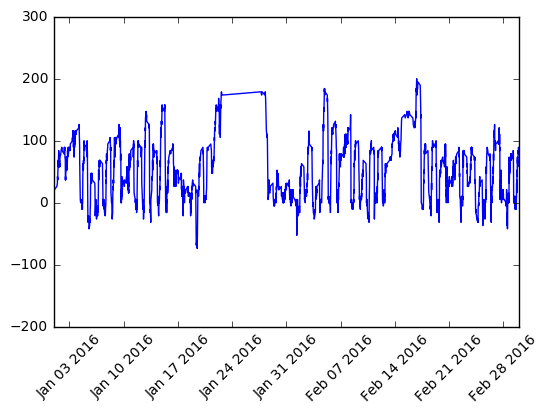

In [3]:
# For a random, specific station, 31116, what did the time series look like?
original_data_31116 = original_data[original_data['Station_Number'] == 31116]

plt.plot(original_data_31116['Date'], original_data_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [44]:
# Explore descriptive stats for percent capacity
original_data_31116['Count_Percent_Capacity'].describe()

count    50836.000000
mean        57.821850
std         52.297961
min        -94.736842
25%         15.789474
50%         47.368421
75%         94.736842
max        268.421053
Name: Count_Percent_Capacity, dtype: float64

# What does the data look like after transformations?

In [4]:
# Load the new, transformed data set
transformed_data = pd.read_csv('transformed_data.csv')
transformed_data['Date'] = pd.to_datetime(transformed_data['Date'], infer_datetime_format=True)

# Display
transformed_data.head()

,Unnamed: 0,Date,Station_Number,Count_Percent_Capacity
0,0,2015-07-01 08:25:00,31116,5.263158
1,1,2015-07-01 08:26:00,31116,0.000000
2,2,2015-07-01 09:42:00,31116,5.263158
3,3,2015-07-01 09:55:00,31116,0.000000
4,4,2015-07-01 10:38:00,31116,5.263158


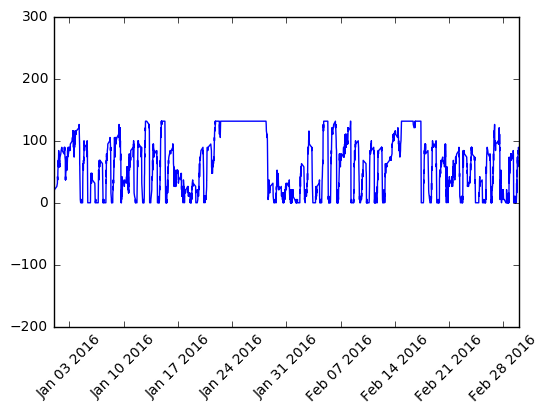

In [5]:
# For a random, specific station, 31116, what did the time series look like?
transformed_data_31116 = transformed_data[transformed_data['Station_Number'] == 31116]

plt.plot(transformed_data_31116['Date'], transformed_data_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [43]:
# Did tranforming change percent capacity?
transformed_data_31116['Count_Percent_Capacity'].describe()

count    50836.000000
mean        55.921208
std         44.691566
min          0.000000
25%         15.789474
50%         47.368421
75%         94.736842
max        131.578947
Name: Count_Percent_Capacity, dtype: float64

# Upsample the transformed data to every hour

In [9]:
# Use linear interpolation to find data at every hour since the start of the data for station 31116
new_series_31116 = pd.DataFrame()
add_hour = datetime.timedelta(hours=1)

temp_df = transformed_data_31116[transformed_data_31116['Station_Number'] == 31116]

start = temp_df['Date'].iloc[0] + datetime.timedelta(seconds=1)
end = temp_df['Date'].iloc[-1]
new_datetimes = []

while start <= (end + add_hour):
    new_datetimes.append(start)
    start += add_hour

new_datetimes_df = pd.DataFrame({'Date':new_datetimes, 
                                 'Station_Number':'new_datetime'})

updated_temp_df = temp_df.append(new_datetimes_df)
updated_temp_df.sort_values(by='Date', inplace=True)
#updated_temp_df.fillna(method='ffill', inplace=True)
updated_temp_df['Count_Percent_Capacity'] = updated_temp_df['Count_Percent_Capacity'].interpolate(method='linear')
updated_temp_df = updated_temp_df[updated_temp_df['Station_Number'] != 31116]
updated_temp_df['Station_Number'] = 31116

new_series_31116 = new_series_31116.append(updated_temp_df)

In [45]:
# Display
new_series_31116.head()

,Count_Percent_Capacity,Date,Station_Number,Unnamed: 0
0,2.631579,2015-07-01 08:25:01,31116,NaN
1,2.631579,2015-07-01 09:25:01,31116,NaN
2,2.631579,2015-07-01 10:25:01,31116,NaN
3,1.315789,2015-07-01 11:25:01,31116,NaN
4,2.631579,2015-07-01 12:25:01,31116,NaN


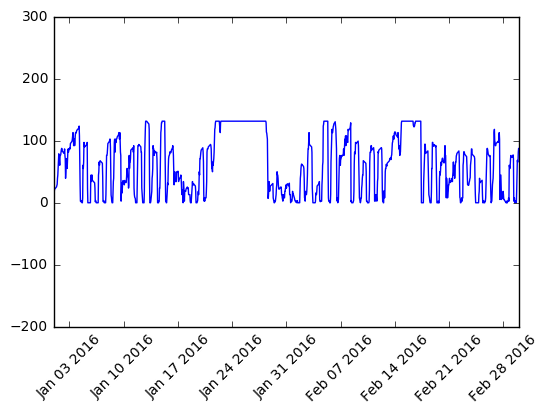

In [11]:
# Does it look like the upsampling changed the representation of the data?
plt.plot(new_series_31116['Date'], new_series_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [42]:
# Did upsampling change percent capacity?
new_series_31116['Count_Percent_Capacity'].describe()

count    10985.000000
mean        62.335961
std         48.511890
min          0.000000
25%         13.157895
50%         60.526316
75%        107.894737
max        131.578947
Name: Count_Percent_Capacity, dtype: float64

# Try an ARIMA model on the upsampled data for station 31116

In [12]:
# Take the subset of transformed data for station 31116 as a series object
#series_31116 = transformed_data_31116[['Date', 'Count_Percent_Capacity']]
series_31116 = new_series_31116.copy()
series_31116.set_index('Date', inplace=True)
series_31116 = series_31116['Count_Percent_Capacity']

# Display
series_31116 .head()

Date
2015-07-01 08:25:01    2.631579
2015-07-01 09:25:01    2.631579
2015-07-01 10:25:01    2.631579
2015-07-01 11:25:01    1.315789
2015-07-01 12:25:01    2.631579
Name: Count_Percent_Capacity, dtype: float64

In [13]:
# Create function for stationarity test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.DataFrame.rolling(timeseries, window=12,center=False).mean()
    rolstd = pd.DataFrame.rolling(timeseries, window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

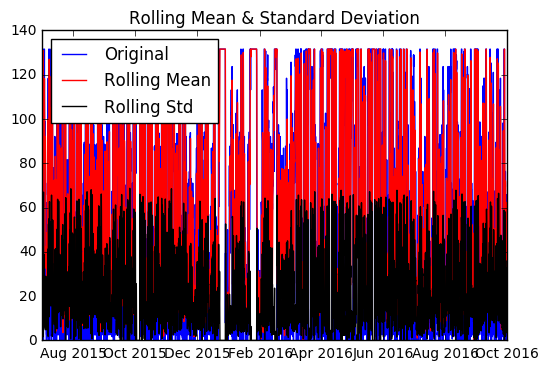

Results of Dickey-Fuller Test:
Test Statistic                -1.219115e+01
p-value                        1.284862e-22
#Lags Used                     3.800000e+01
Number of Observations Used    1.094600e+04
Critical Value (1%)           -3.430948e+00
Critical Value (10%)          -2.566911e+00
Critical Value (5%)           -2.861804e+00
dtype: float64


In [14]:
# Run a test for stationarity on series_31116
test_stationarity(series_31116)

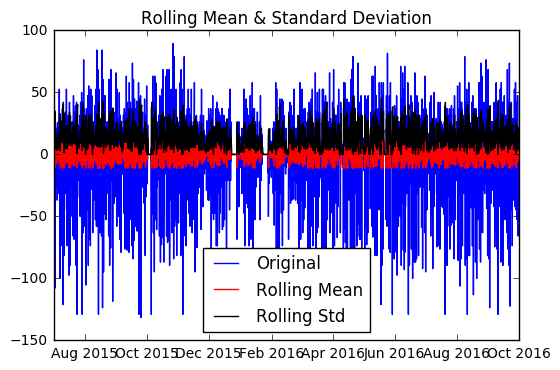

Results of Dickey-Fuller Test:
Test Statistic                   -23.506057
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    10944.000000
Critical Value (1%)               -3.430948
Critical Value (10%)              -2.566911
Critical Value (5%)               -2.861804
dtype: float64


In [15]:
# Dickey_Fuller Test above shows that the series is stationary

# Induce further stationarity by differencing
series_31116_diff = series_31116 - series_31116.shift()
series_31116_diff.dropna(inplace=True)

# Run another test for stationarity on the differenced series
test_stationarity(series_31116_diff)

In [16]:
# Above test for stationarity shows that differenced series is even more stationary. As expected.

In [17]:
# Create ACF and PACF plots as inputs to the ARIMA model
lag_pacf = pacf(series_31116_diff, nlags=20, method='ols')

(-0.05, 0.05)

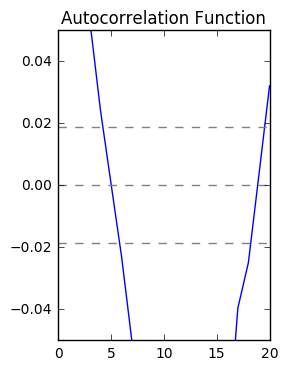

In [18]:
# Plot ACF: 
lag_acf = acf(series_31116_diff, nlags=20)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_31116_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_31116_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.ylim(-.05, .05)

(-0.05, 0.05)

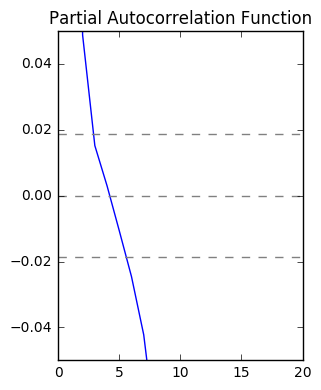

In [19]:
# Plot PACF:
lag_pacf = pacf(series_31116_diff, nlags=20, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_31116_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_31116_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.ylim(-.05, .05)

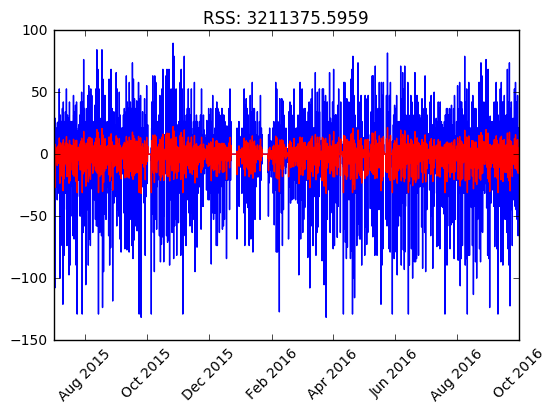

In [30]:
# AR Model
model = ARIMA(series_31116, order=(4, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(series_31116_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-series_31116_diff)**2))
plt.xticks(rotation=45);

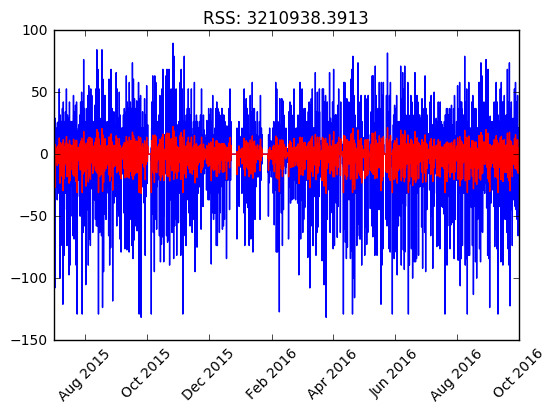

In [32]:
# MA Model
model = ARIMA(series_31116, order=(0, 1, 5))  
results_MA = model.fit(disp=-1)  
plt.plot(series_31116_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-series_31116_diff)**2))
plt.xticks(rotation=45);

/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


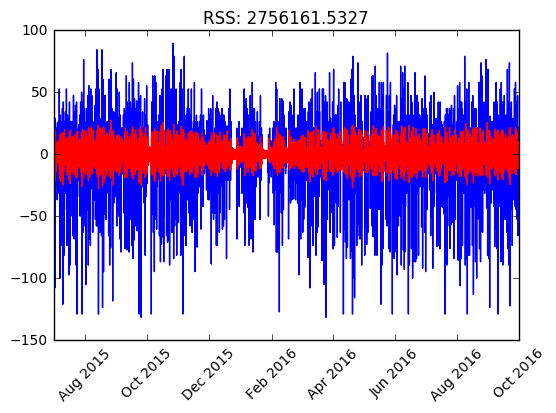

In [41]:
# Combined ARIMA Model
model = ARIMA(series_31116, order=(4, 1, 5))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(series_31116_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-series_31116_diff)**2))
plt.xticks(rotation=45);

In [46]:
results_ARIMA.summary()

/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                 
====================================================================================
Dep. Variable:     D.Count_Percent_Capacity   No. Observations:                10984
Model:                       ARIMA(4, 1, 5)   Log Likelihood              -45929.603
Method:                             css-mle   S.D. of innovations             15.834
Date:                      Wed, 29 Mar 2017   AIC                          91881.205
Time:                              10:28:24   BIC                          91961.552
Sample:                          07-01-2015   HQIC                         91908.276
                               - 10-01-2016                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0014      0.091     -0.015      0.988      -0.179       0.177
ar.L1.D.Count_Percent_Capacity     1.8945        nan        nan        nan         nan         nan
ar.L2.D.Count_Percent_Capacity    -1.9543        nan        nan        nan         nan         nan
ar.L3.D.Count_Percent_Capacity     1.8944        nan        nan        nan         nan         nan
ar.L4.D.Count_Percent_Capacity    -0.9545      0.000  -3454.163      0.000      -0.955      -0.954
ma.L1.D.Count_Percent_Capacity    -1.7721      0.010   -185.707      0.000      -1.791      -1.753
ma.L2.D.Count_Percent_Capacity     1.7357      0.018     95.963      0.000       1.700       1.771
ma.L3.D.Count_Percent_Capacity    -1.6980      0.019    -91.722      0.000      -1.734      -1.662
ma.L4.D.Count_Percent_Capacity     0.7374      0.018     40.610      0.000       0.702       0.773
ma.L5.D.Count_Percent_Capacity     0.0690      0.009      7.314      0.000       0.051       0.088
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0001           -1.0000j            1.0000           -0.2500
AR.2           -0.0001           +1.0000j            1.0000            0.2500
AR.3            0.9924           -0.2504j            1.0236           -0.0393
AR.4            0.9924           +0.2504j            1.0236            0.0393
MA.1           -0.0003           -1.0014j            1.0014           -0.2500
MA.2           -0.0003           +1.0014j            1.0014            0.2500
MA.3            1.0465           -0.1888j            1.0634           -0.0284
MA.4            1.0465           +0.1888j            1.0634            0.0284
MA.5          -12.7752           -0.0000j           12.7752           -0.5000
-----------------------------------------------------------------------------
"""

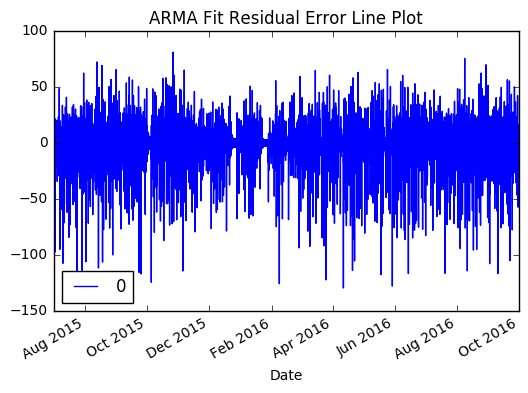

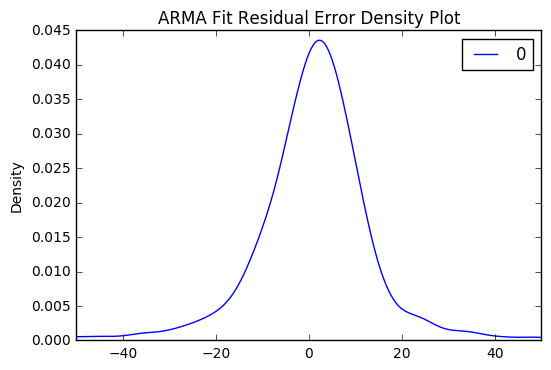

Describe residuals:
                  0
count  10984.000000
mean       0.006844
std       15.841336
min     -129.541136
25%       -5.058344
50%        1.435839
75%        7.263085
max       81.057789


In [53]:
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.title('ARMA Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.xlim(-50,50)
plt.title('ARMA Fit Residual Error Density Plot')
plt.show()

print('Describe residuals:')
print(residuals.describe())

In [101]:
X = series_31116_diff.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=-21.878727, expected=-68.421053
predicted=-35.339571, expected=-0.877193
predicted=-17.417345, expected=1.754386
predicted=-13.707696, expected=4.385965
predicted=-11.160415, expected=10.526316
predicted=-9.131955, expected=-10.526316
predicted=-10.157311, expected=-5.263158
predicted=-1.782824, expected=21.052632
predicted=8.012444, expected=26.315789
predicted=13.493303, expected=47.368421
predicted=24.910311, expected=15.789474
predicted=16.855473, expected=13.157895
predicted=17.853940, expected=0.000000
predicted=14.115122, expected=0.000000
predicted=11.589528, expected=0.000000
predicted=8.712732, expected=0.000000
predicted=3.325094, expected=0.000000
predicted=1.567549, expected=0.000000
predicted=-0.000079, expected=0.000000
predicted=-0.000078, expected=0.000000
predicted=-0.000084, expected=0.000000
predicted=-0.000086, expected=0.000000
predicted=-0.000082, expected=-39.473684
predicted=-15.693784, expected=-89.473684
predicted=-41.485328, expected=-2.631579
pred

/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=-0.922636, expected=-0.877193
predicted=-1.564456, expected=10.526316
predicted=3.077517, expected=-10.526316
predicted=-3.729879, expected=10.526316
predicted=3.347768, expected=10.526316
predicted=5.580303, expected=-5.263158
predicted=0.768607, expected=5.263158
predicted=3.803496, expected=-5.263158
predicted=-1.022416, expected=0.000000
predicted=1.774192, expected=10.526316
predicted=4.728419, expected=13.157895
predicted=6.207016, expected=0.000000
predicted=3.301285, expected=0.000000
predicted=2.089777, expected=0.000000
predicted=2.481490, expected=0.000000
predicted=2.701845, expected=0.000000
predicted=1.565779, expected=0.000000
predicted=-0.000080, expected=0.000000
predicted=-0.000082, expected=0.000000
predicted=-0.000083, expected=0.000000
predicted=-0.000083, expected=0.000000
predicted=-0.000086, expected=0.000000
predicted=-0.000080, expected=0.000000
predicted=-0.000088, expected=0.000000
predicted=-0.000087, expected=0.000000
predicted=-0.000084, expecte

/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=-7.460777, expected=-10.526316
predicted=-9.653059, expected=15.789474
predicted=-0.881678, expected=-15.789474
predicted=-8.779681, expected=15.789474
predicted=4.575834, expected=13.157895
predicted=5.013574, expected=-23.684211
predicted=-6.626660, expected=2.631579
predicted=0.799380, expected=-0.000000
predicted=-1.133580, expected=0.000000
predicted=1.106788, expected=-7.894737
predicted=-3.818264, expected=5.263158
predicted=-1.720199, expected=-7.894737
predicted=-2.889001, expected=0.000000
predicted=-1.446799, expected=0.000000
predicted=-1.225658, expected=0.000000
predicted=-1.224749, expected=0.000000
predicted=-0.230556, expected=0.000000
predicted=-0.951298, expected=0.000000
predicted=-0.000065, expected=0.000000
predicted=-0.000057, expected=1.754386
predicted=0.686287, expected=1.754386
predicted=0.956314, expected=-3.508772
predicted=-0.896588, expected=0.000000
predicted=-0.145177, expected=2.631579
predicted=0.998204, expected=5.263158
predicted=2.489824,

Test MSE: 384.694


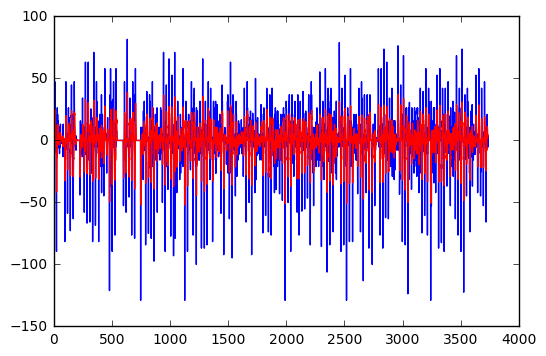

In [107]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()